### Load in Data

In [59]:
import pandas as pd
import glob

# Get a list of all cringe csv files
cringe_list = glob.glob('Dataset(.csv)/CringeData/*.csv')
cringe_list_size = len(cringe_list)

# Initalize dataframe which will hold mergedcsv files
cringeDF = pd.DataFrame()

# Go through list and give each file a videoID and label of 0
for i in range(0, cringe_list_size):
    tempDF = pd.read_csv(cringe_list[i])
    tempDF['video_id'] = str(i) + 'c'
    tempDF['label'] = 0
    
    # Merge file into cringeDF
    cringeDF= cringeDF.append(tempDF)
    
    # Reset index
    cringeDF.reset_index()

    
# Get a list of all pain csv files
pain_list = glob.glob('Dataset(.csv)/PainData/*.csv')
pain_list_size = len(pain_list)

# Initialize dataframe which will hold merged csv files
painDF = pd.DataFrame()

# Go through list and give each file a videoID and label of 1
for i in range(0, pain_list_size):
    tempDF = pd.read_csv(pain_list[i])
    tempDF['video_id'] = str(i) + 'p'
    tempDF['label'] = 1
    
    # Merge file into cringeDF
    painDF= painDF.append(tempDF)
    
    # Reset index
    painDF.reset_index()
            

### Clean Data and Select Features

In [60]:
from sklearn.preprocessing import StandardScaler

# Filter out unsuccessful and low confidence frames
cringeDF = cringeDF.loc[cringeDF['confidence'] > 0.8]
cringeDF = cringeDF.loc[cringeDF['success'] == 1]

painDF = painDF.loc[painDF['confidence'] > 0.8] 
painDF = painDF.loc[painDF['success'] == 1]

# Merge all csv entries and all cols
combinedDF = cringeDF.append(painDF)
combinedDF = combinedDF.reset_index()

# Only select AU intensities
feature_list = ['AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r',
                'AU09_r', 'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r',
                'AU20_r', 'AU23_r', 'AU25_r', 'AU26_r', 'AU45_r']

featuresDF = combinedDF.loc[:,feature_list]

# Standardize data
standardScaler = StandardScaler()
featuresDF = standardScaler.fit_transform(featuresDF)

### Use PCA for Visualization

In [61]:
from sklearn.decomposition import PCA

# Initialize PCA and choose number of componenets to keep
pca = PCA(n_components=2)

# Conduct PCA to reduce to two components
reducedDimensions = pca.fit_transform(featuresDF)

print("The explained variance of two components: ", pca.explained_variance_ratio_) 

# Create a df of the two components
pcaDF = pd.DataFrame(data = reducedDimensions, columns = ['principal component 1', 'principal component 2'])

pcaDF

The explained variance of two components:  [0.19636346 0.12467418]


,principal component 1,principal component 2
0,2.261320,-0.847742
1,2.142085,-1.383729
2,2.059993,-1.663526
3,1.952885,-1.761905
4,2.017406,-1.828222
...,...,...
10404,-2.161814,-0.014878
10405,-2.194161,0.016014
10406,-2.160493,0.122005
10407,-2.166608,-0.059520


### GMM Covariance Selection

In [62]:
# Using scikit-learn code from: 
# https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py

from sklearn import mixture

X = pcaDF
lowest_bic = np.infty
bic = []
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    # Fit a Gaussian mixture with EM
    gmm = mixture.GaussianMixture(
        n_components=2, covariance_type=cv_type
    )
    gmm.fit(X)
    bic.append(gmm.bic(X))
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_gmm = cv_type
        
print("The best covariance for k=2 is:",best_gmm)


The best covariance for k=2 is: full


### GMM Clustering Visualization

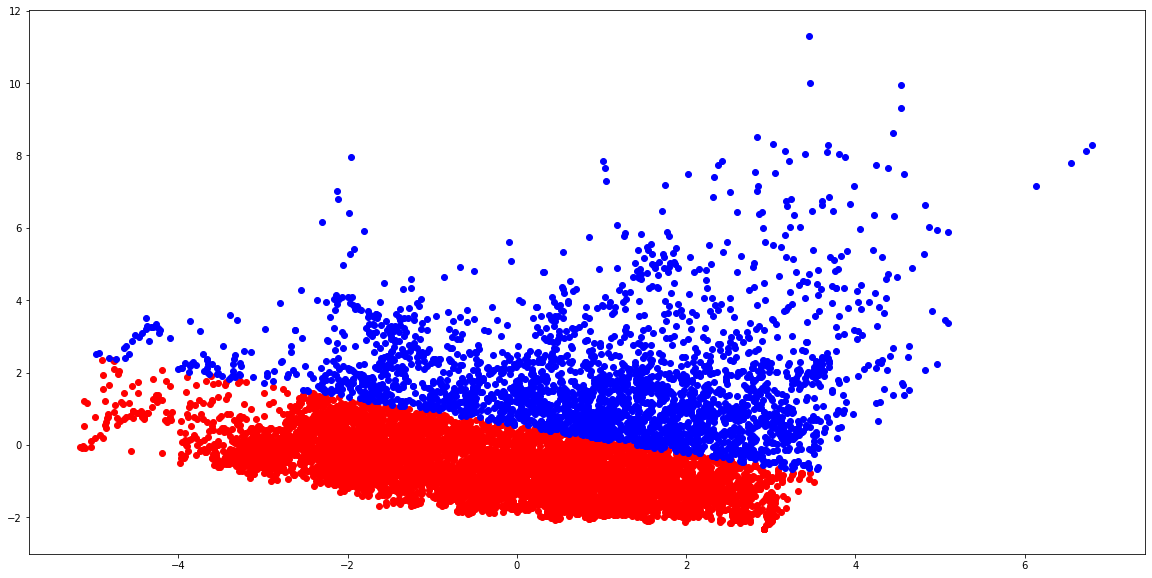

In [63]:
# Using scikit-learn code from: 
# https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py
import numpy as np
import matplotlib.pyplot as plt


from sklearn import mixture

gmm = mixture.GaussianMixture(
        n_components=2, covariance_type="full"
    )
gmm.fit(X)
labels = gmm.predict(X)

#filter rows of original data (https://www.askpython.com/python/examples/plot-k-means-clusters-python)
filtered_label0 = pcaDF[labels == 0]
filtered_label1 = pcaDF[labels == 1]

#Plotting the results (https://www.askpython.com/python/examples/plot-k-means-clusters-python)
plt.figure(figsize=(20, 10))
plt.scatter(filtered_label0['principal component 1'] , filtered_label0['principal component 2'], color = 'red')
plt.scatter(filtered_label1['principal component 1'] , filtered_label1['principal component 2'] , color = 'blue')
